In [1]:
import numpy as np
import random
import itertools
import pandas as pd
import multiprocessing
import math
import scipy.stats as ss
import seaborn as sns
import pickle
import re
import copy
from keras.utils import np_utils

from opyenxes.model.XLog import XLog
from opyenxes.data_in.XUniversalParser import XUniversalParser
from opyenxes.classification.XEventAttributeClassifier import XEventAttributeClassifier

from prefixspan import PrefixSpan

from tqdm import tqdm_notebook

Using TensorFlow backend.


In [2]:
### configuration
data_path = "../logs/bpic2011.xes"
traces_picklepath  = data_path.replace(".xes", "_raw_traces.pickled")
traces_dictionarypath = data_path.replace(".xes", "_dictionaries.pickled")
target_column = "concept:name"
categorical_feature_names = ["concept:name", "Section", "org:group"]
eosmarker = "<EOS>"
### configuration end

In [5]:
with open(data_path) as bpic_file:
    eventlog = XUniversalParser().parse(bpic_file)[0]

Unknown extension: http://www.xes-standard.org/meta_time.xesext
Unknown extension: http://www.xes-standard.org/meta_life.xesext
Unknown extension: http://www.xes-standard.org/meta_org.xesext
Unknown extension: http://www.xes-standard.org/meta_concept.xesext
Unknown extension: http://www.xes-standard.org/meta_3TU.xesext
Unknown extension: http://www.xes-standard.org/meta_general.xesext


In [3]:
ncores = multiprocessing.cpu_count()
ntraces = len(eventlog)

NameError: name 'eventlog' is not defined

## Extract data trace-wise from XES format

In [ ]:
# collect all attributes
column_names = []

for event in eventlog[0]:
    for attribute in event.get_attributes():
        column_names.append(attribute)
        
column_names = set(column_names) # remove duplicates
column_names = list(column_names)

def create_dataframe_from_trace(t):
    df = pd.DataFrame(columns=column_names, index=range(0,len(t)))
    for event_idx, event in enumerate(t):
        event_attributes = event.get_attributes()
        df.iloc[event_idx]["__case_id"] = 0
        
        for attribute in event_attributes:
            df[attribute].values[event_idx] = event_attributes[attribute].get_value()
    
    return df

ppool = multiprocessing.Pool(ncores)
traces = []

for _ in tqdm_notebook(ppool.imap(create_dataframe_from_trace, eventlog),
                       total=len(eventlog),
                       unit="traces"):
        traces.append(_)

ppool.close()
del eventlog

In [ ]:
pickle.dump(traces, open(traces_picklepath, "wb"))

In [41]:
traces = pickle.load(open(traces_picklepath, "rb"))

## Create complete feature set

In [42]:
for i in range(0,len(traces)):
    traces[i]["org:group"].fillna("NULL", inplace=True)
    traces[i]["Section"].fillna("NULL", inplace=True)

eventlog_df = pd.concat(traces, ignore_index=True)

for col in eventlog_df.columns:
    if eventlog_df[col].nunique() == 1:
        for t in traces:
            t.drop(columns=[col], inplace=True)
        eventlog_df.drop(columns=[col], inplace=True)
        print("Dropped column because it contains only a single value:", col)

Dropped column because it contains only a single value: lifecycle:transition


## Eliminate correlated or unimportant features

In [43]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
        https://stackoverflow.com/questions/46498455/categorical-features-correlation"""
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cramers_v_df = pd.DataFrame(index=eventlog_df.columns,
                            columns=eventlog_df.columns,
                            dtype=np.float)

for col_a,col_b in itertools.product(eventlog_df.columns, repeat=2):   
    if col_a == col_b:
        cramers_v_df[col_a][col_b] = 1
    else:
        candidate = pd.crosstab(eventlog_df[col_a], eventlog_df[col_b]).as_matrix()
        cramers_v_df[col_a][col_b] = cramers_v(candidate)

/home/felix.wolff2/anaconda3/envs/thesis/lib/python3.6/site-packages/ipykernel/__main__.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


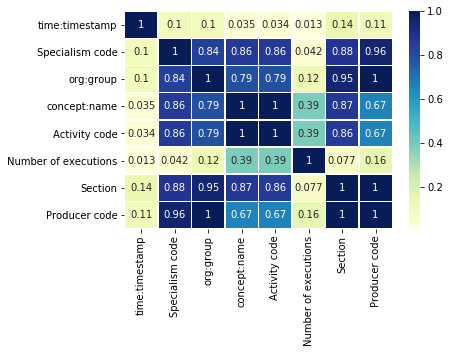

In [44]:
sns.heatmap(cramers_v_df, annot=True, linewidths=.5, cmap="YlGnBu")

In [45]:
# lifecyle:transition is always "complete"
# Producer code correlates perfectly with org:group
# Activity code correlates perfectly with concept:name
for t in traces:
    t.drop(columns=["Producer code", "Activity code", "Specialism code"], inplace=True)

## Convert timestamps to relative scale in hours

In [46]:
# Convert timestamp to total running time in hours
bos_idx = 0
for i in range(0, len(traces)):
    tlen = len(traces[i])-1
    dfs = traces[i]["time:timestamp"] - traces[i]["time:timestamp"][bos_idx]
    traces[i]["time:timestamp"] = dfs.map(lambda d: int(d.total_seconds()/(60*60)))

## Dictionary encoding for categorical features

In [47]:
feature_dict = {}
for cf in categorical_feature_names:
    cf_dict = { 'to_int': {}, 'to_cat': {} }
    events = eventlog_df[cf].unique().tolist()
    if cf == target_column: events.append(eosmarker)
    cf_dict['to_int'] = dict((c, i) for i, c in enumerate(events))
    cf_dict['to_cat'] = dict((i, c) for i, c in enumerate(events))
    feature_dict[cf] = cf_dict

## Create SP2 feature set

In [48]:
# loop through every trace and encode the presence of an activity
sp2_prefix = "SP2_"
activity_labels = [ "{0}{1}".format(sp2_prefix,a) for a in eventlog_df["concept:name"].unique() ]

def enrich_trace_with_sp2(t):
    sp2_df = pd.DataFrame(columns=activity_labels, index=range(0,len(t)), dtype=np.bool)
    for col in sp2_df.columns: sp2_df[col].values[:] = 0
    sp2_df["{0}{1}".format(sp2_prefix, t["concept:name"][0])].values[0]  = 1
    
    for i in range(1,len(t)):
        first_activity_name = t["concept:name"].iloc[i]
        col = "{0}{1}".format(sp2_prefix,first_activity_name)
        
        sp2_df.values[i] = sp2_df.values[i-1]
        sp2_df[col].values[i] = 1
        
    return sp2_df

ppool = multiprocessing.Pool(ncores)
sp2_traces = []

for _ in tqdm_notebook(ppool.imap(enrich_trace_with_sp2, traces),
                       total=len(traces),
                       unit="traces"):
        sp2_traces.append(_)
        
ppool.close()

## Create PrefixSpan feature set

In [49]:
# Prefixspan requires an array of arrays with one subarray for every trace
encoded_traces = [ t[target_column].map(feature_dict[target_column]['to_int']).tolist() for t in traces ]
prefixspan_traces = PrefixSpan(encoded_traces)
closed_sequences = prefixspan_traces.topk(25, closed=True) # support is how often the subsequence appears in total
# http://sequenceanalysis.github.io/slides/analyzing_sequential_user_behavior_part2.pdf, slide 5

# only take subsequence which are at a certain level of support? like if ss[0]/len(traces) < .90
#ps_topkc = list(filter(lambda x: x[0]/len(traces) > .90, ps_topkc))
closed_sequences = [ p[1] for p in closed_sequences ]
pftrace_args = [ (t, closed_sequences[:], feature_dict[target_column]['to_int']) for t in traces ] # enrich traces with copy of mined subsequences

In [50]:
def wrapped__enrich_trace_with_subseq(args):
    return enrich_trace_with_subseq(*args)

def enrich_trace_with_subseq(t, ps, event_to_int):
    col_prefix = "PFS_"
    subseq_labels = [ "{0}{1}".format(col_prefix,ss_idx) for ss_idx, ss in enumerate(ps) ]
    subseq_df = pd.DataFrame(columns=subseq_labels, index=range(0,len(t)), dtype=np.bool)
    
    for col in subseq_df.columns: subseq_df[col].values[:] = 0
    for i in range(0,len(t)): # loop through sequence, prune items from mined sequences, and once a subsequence array is empty, this subsequence has occured :)
        activity_code = event_to_int.get(t["concept:name"].iloc[i], None)
        
        for subseq_idx in range(0,len(ps)):
            if ps[subseq_idx] == []:
                continue
            if ps[subseq_idx][0] == activity_code:
                ps[subseq_idx].pop(0)
                if ps[subseq_idx] == []:
                    subseq_df.values[i:,subseq_idx] = 1
        
    return subseq_df

ppool = multiprocessing.Pool(ncores)
pf_traces = []
        
for _ in tqdm_notebook(ppool.imap(wrapped__enrich_trace_with_subseq, pftrace_args),
                       total=len(pftrace_args),
                       unit="traces"):
        pf_traces.append(_)
        
ppool.close()

## Create and normalize ordinal and categorical feature sets

In [51]:
ordinal_feature_names = traces[0].columns.difference(categorical_feature_names)
n_target_classes = max(feature_dict[target_column]['to_int'].values()) + 1
final_traces = copy.deepcopy(traces)

ordinal_traces = [None] * len(traces)
categorical_traces = [None] * len(traces)
target_traces = [None] * len(traces)

# Concatenate all features into one feature dataframe per trace
for i in range(0, len(traces)):
    
    # Create TARGET feature column by shifting target column
    targets = final_traces[i][target_column].shift(-1).map(feature_dict[target_column]['to_int']).to_frame("TARGET")
    targets.values[len(targets)-1] = feature_dict[target_column]['to_int'][eosmarker]
    target_traces[i] = pd.DataFrame(np_utils.to_categorical(targets, num_classes=n_target_classes, dtype='bool')).add_prefix("TARGET_")
    
    # TODO move to network scripts...
    # Encode categorical features and normalize
#     for cf in categorical_feature_names:
#         final_traces[i][cf] = traces[i][cf].map(feature_dict[cf]['to_int'])
#         final_traces[i][cf] /= n_target_classes

    # Create separate dfs for ordinal and categorical traces
    ordinal_traces[i] = final_traces[i][ordinal_feature_names].astype(np.float32)
    categorical_traces[i] = final_traces[i][categorical_feature_names].astype(np.str)
    
#     final_traces[i] = pd.concat([ordinal_trace,
#                                  categorical_trace,
#                                  sp2_traces[i],
#                                  pf_traces[i],
#                                  targets],
#                                 ignore_index=False, axis=1)
del final_traces

## Create and save training and test sets per variable type

In [52]:
random.seed(123); random.shuffle(categorical_traces)
random.seed(123); random.shuffle(ordinal_traces)
random.seed(123); random.shuffle(target_traces)
random.seed(123); random.shuffle(sp2_traces)
random.seed(123); random.shuffle(pf_traces)

assert(len(ordinal_traces[0]) ==
       len(categorical_traces[0]) ==
       len(target_traces[0]) ==
       len(sp2_traces[0]) ==
       len(pf_traces[0]))

In [55]:
feature_dict['concept:name']['to_int']["histologisch onderzoek - biopten nno"]

101

In [54]:
categorical_traces[3]

,concept:name,Section,org:group
0,vervolgconsult poliklinisch,Section 2,Obstetrics & Gynaecology clinic
1,vervolgconsult poliklinisch,Section 2,Obstetrics & Gynaecology clinic
2,administratief tarief - eerste pol,Section 2,Obstetrics & Gynaecology clinic
3,histologisch onderzoek - biopten nno,Section 4,Pathology
4,vervolgconsult poliklinisch,Section 2,Obstetrics & Gynaecology clinic
5,administratief tarief - eerste pol,Section 2,Obstetrics & Gynaecology clinic
6,telefonisch consult,Section 2,Obstetrics & Gynaecology clinic
7,aanname laboratoriumonderzoek,Section 4,General Lab Clinical Chemistry
8,aanname laboratoriumonderzoek,Section 4,General Lab Clinical Chemistry
9,aanname laboratoriumonderzoek,Section 4,General Lab Clinical Chemistry


In [53]:
def save_trace_dataset(dataset, purpose='categorical', ttype='test'):
    suffix = "_{0}_{1}.pickled".format(purpose, ttype)
    p = data_path.replace(".xes", suffix)
    pickle.dump(dataset, open(p, "wb"), protocol=pickle.HIGHEST_PROTOCOL)
    
set_sep_idx = 900
save_trace_dataset(feature_dict, 'mapping', 'dict',)

save_trace_dataset(ordinal_traces[:set_sep_idx], 'ordinal', 'train')
save_trace_dataset(categorical_traces[:set_sep_idx], 'categorical', 'train')
save_trace_dataset(sp2_traces[:set_sep_idx], 'sp2', 'train')
save_trace_dataset(pf_traces[:set_sep_idx], 'pfs', 'train')
save_trace_dataset(target_traces[:set_sep_idx], 'target', 'train')

save_trace_dataset(ordinal_traces[set_sep_idx:], 'ordinal', 'test')
save_trace_dataset(categorical_traces[set_sep_idx:], 'categorical', 'test')
save_trace_dataset(sp2_traces[set_sep_idx:], 'sp2', 'test')
save_trace_dataset(pf_traces[set_sep_idx:], 'pfs', 'test')
save_trace_dataset(target_traces[set_sep_idx:], 'target', 'test')